# APPLYING CLIP

## Install necessary libraries

In [1]:
!unzip /content/drive/MyDrive/data.zip -d /content/data

Archive:  /content/drive/MyDrive/data.zip
   creating: /content/data/data/
  inflating: /content/data/data/steam_apps_trailers.csv  
  inflating: /content/data/data/steam_apps_developers.csv  
  inflating: /content/data/data/steam_apps_images.csv  
  inflating: /content/data/data/steam_apps_info.csv  
  inflating: /content/data/data/steam_apps_publishers.csv  
  inflating: /content/data/data/steam_apps_reviews.csv  


In [2]:
%%capture
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install requests
!pip install spacy
!python -m spacy download en_core_web_sm

In [27]:
import pandas as pd
import random
import shutil
import os
import spacy
from collections import Counter
import requests
from tqdm import tqdm  # For progress bar
from PIL import Image
from IPython.display import display
import numpy as np
import clip
import torch
import matplotlib.pyplot as plt
from io import BytesIO

## Load dataset


Load data

In [ ]:
# Load datasets
steam_app_images = pd.read_csv("/content/data/data/steam_apps_images.csv")
steam_apps_info = pd.read_csv("/content/data/data/steam_apps_info.csv")

# Inspect data
print(steam_app_images.head())
print(steam_apps_info.head())


   image_id  steam_app_id   image_type  \
0         0       2532180       header   
1         1       2532180      capsule   
2         2       2532180  description   
3         3       2532180  description   
4         4       2532180  description   

                                           image_url  
0  https://shared.akamai.steamstatic.com/store_it...  
1  https://shared.akamai.steamstatic.com/store_it...  
2  https://shared.akamai.steamstatic.com/store_it...  
3  https://shared.akamai.steamstatic.com/store_it...  
4  https://shared.akamai.steamstatic.com/store_it...  
   steam_app_id                steam_app_name app_type  \
0       2532180              DEAD END MISSION     game   
1       2532230   SCP: Nemesi - Alpha Testing     game   
2       2532300               The Weird Dream     game   
3       2532310                     Line Link     game   
4       2532360  Point Salad - The Board Game     game   

                                         description  total_reviews 

delete existing folder

In [ ]:
folder_path = '/content/images'

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"The folder {folder_path} and all its contents have been deleted.")
else:
    print(f"The folder {folder_path} does not exist.")


The folder /content/images does not exist.


## Preprocessing

* select only a portion of dataset (to save training time)

* convert descriptions to keywords only

* remove 404 error URLs

* create a temp folder with images

select only a portion of dataset (to save training time)

In [ ]:
# Select random games
dataset_selected = 50
selected_games = steam_apps_info.sample(dataset_selected, random_state=42)
selected_game_ids = selected_games['steam_app_id'].tolist()
print(f"Selected Game IDs: {selected_game_ids}")


Selected Game IDs: [1097960, 1084860, 1266070, 1120461, 2484670, 1130990, 2417700, 1212690, 2325880, 1375270, 1389830, 1254700, 2425050, 1270620, 2264940, 1266440, 1285610, 731180, 2370540, 2254780, 1070400, 1145360, 1246390, 1127620, 1376470, 1178870, 1189060, 2239140, 1138260, 1121620, 1233600, 2243660, 1244470, 2368100, 1112620, 1088540, 1243160, 1068720, 1092000, 1194010, 2334534, 1114230, 2522450, 1239490, 1320230, 1227040, 1058760, 1203880, 2482130, 1109205]


convert descriptions to keywords only

In [ ]:
nlp = spacy.load("en_core_web_sm")

def clean_description(description, max_keywords=10):
    if not isinstance(description, str):
        # Return an empty string or a placeholder if the description is not valid
        return ""

    # Process the description with spaCy
    doc = nlp(description.lower())

    # Extract nouns, proper nouns, and significant keywords
    keywords = [
        token.text for token in doc
        if token.is_alpha and not token.is_stop and token.pos_ in {"NOUN", "PROPN", "ADJ"}
    ]

    # Count keyword frequencies to prioritize frequent ones
    keyword_freq = Counter(keywords)

    # Return the top `max_keywords` most common keywords
    top_keywords = [word for word, freq in keyword_freq.most_common(max_keywords)]
    return " ".join(top_keywords)

# Apply the updated function to handle missing or invalid descriptions
selected_games['cleaned_description'] = selected_games['description'].apply(
    lambda x: clean_description(x, max_keywords=10)
)

# Display results
print(selected_games[['steam_app_id', 'cleaned_description']])


       steam_app_id                                cleaned_description
22135       1097960  br game party skills unique team idle gems cla...
22714       1084860  br risk system deluxe content original light e...
14642       1266070  stage healthy box vr fitness game people willi...
21109       1120461      lord zedd character power rangers battle grid
1045        2484670  chess game games remix world rules new play sh...
20667       1130990  br roman romans evil britons level welcome sea...
2714        2417700  unique steam extras strong malice platformer a...
16973       1212690  borg instructors mountain faulty apprentice dl...
5312        2325880  game heroes players battle deck zodiac abiliti...
10495       1375270  maze steam extras shadow reborn ego shape expe...
9939        1389830  electronic components power steam extras robot...
15236       1254700                                             format
2533        2425050  steam extras person night fang mysterious new ...
14438 

remove 404 error URLs

In [ ]:
def is_valid_url(url):
    try:
        response = requests.head(url, timeout=5)
        return response.status_code == 200
    except:
        return False

# Filter images for selected games
selected_images = steam_app_images[steam_app_images['steam_app_id'].isin(selected_game_ids)].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Use tqdm for progress bar
tqdm.pandas(desc="Validating URLs")

# Validate URLs and show progress
selected_images['is_valid_url'] = selected_images['image_url'].progress_apply(is_valid_url)

# Filter out valid images
valid_images = selected_images[selected_images['is_valid_url']]

# Display valid images
print(valid_images[['steam_app_id', 'image_url', 'image_type']])


Validating URLs: 100%|██████████| 588/588 [00:24<00:00, 24.22it/s]

        steam_app_id                                          image_url  \
2487         2522450  https://shared.akamai.steamstatic.com/store_it...   
2488         2522450  https://shared.akamai.steamstatic.com/store_it...   
2489         2522450  https://shared.akamai.steamstatic.com/store_it...   
2490         2522450  https://shared.akamai.steamstatic.com/store_it...   
2491         2522450  https://shared.akamai.steamstatic.com/store_it...   
...              ...                                                ...   
269667        731180  https://shared.akamai.steamstatic.com/store_it...   
269668        731180  https://shared.akamai.steamstatic.com/store_it...   
269669        731180  https://shared.akamai.steamstatic.com/store_it...   
269670        731180  https://shared.akamai.steamstatic.com/store_it...   
269671        731180  https://shared.akamai.steamstatic.com/store_it...   

         image_type  
2487         header  
2488        capsule  
2489    description  
2490    des

create temp folder with images

In [ ]:
# Create a directory to store downloaded images
os.makedirs("images", exist_ok=True)

# Define the download_image function
def download_image(row):
    try:
        img_data = requests.get(row['image_url'], timeout=10).content  # Add a timeout to prevent hanging
        file_path = f"images/{row['steam_app_id']}_{row['image_type']}.jpg"
        with open(file_path, 'wb') as handler:
            handler.write(img_data)
        return file_path
    except:
        return None

# Use tqdm to wrap the DataFrame
tqdm.pandas(desc="Downloading Images")

# Apply the download_image function with a progress bar
valid_images['local_path'] = valid_images.progress_apply(download_image, axis=1)

# Drop rows where the image download failed
valid_images = valid_images.dropna(subset=['local_path'])

# Print results
print(valid_images[['steam_app_id', 'local_path']])


        steam_app_id                      local_path
2487         2522450       images/2522450_header.jpg
2488         2522450      images/2522450_capsule.jpg
2489         2522450  images/2522450_description.jpg
2490         2522450  images/2522450_description.jpg
2491         2522450  images/2522450_description.jpg
...              ...                             ...
269667        731180    images/731180_screenshot.jpg
269668        731180    images/731180_screenshot.jpg
269669        731180    images/731180_screenshot.jpg
269670        731180    images/731180_screenshot.jpg
269671        731180    images/731180_screenshot.jpg

[588 rows x 2 columns]


## Run the CLIP model

In [ ]:
# Load CLIP model and preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Preprocess images
image_paths = valid_images['local_path'].tolist()
images = [preprocess(Image.open(img_path)).unsqueeze(0) for img_path in image_paths]
images = torch.cat(images, dim=0).to(device)


In [ ]:
# Tokenize descriptions
text_inputs = clip.tokenize(selected_games['cleaned_description'].tolist()).to(device)

# Encode images and text
with torch.no_grad():
    image_features = model.encode_image(images)
    text_features = model.encode_text(text_inputs)

# Normalize features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Calculate similarities
similarities = (image_features @ text_features.T).cpu().numpy()
print("Similarity scores:")
print(similarities)


Similarity scores:
[[0.1638 0.2218 0.1312 ... 0.169  0.1782 0.1259]
 [0.1913 0.2017 0.1605 ... 0.1886 0.2017 0.1562]
 [0.22   0.232  0.2188 ... 0.2515 0.23   0.208 ]
 ...
 [0.2034 0.251  0.2646 ... 0.2292 0.2242 0.2021]
 [0.2034 0.251  0.2646 ... 0.2292 0.2242 0.2021]
 [0.2034 0.251  0.2646 ... 0.2292 0.2242 0.2021]]


## Testing the CLIP Model
* Get custom descriptions for new images using CLIP


In [22]:
import pandas as pd
import ast

# Load the CSV file
file_path = "/content/data/data/steam_apps_info.csv"
df = pd.read_csv(file_path)

# Safely parse the genres column
def safe_eval(val):
    if pd.isna(val):  # Handle NaN values
        return []
    try:
        return ast.literal_eval(val)  # Convert string to list
    except (ValueError, SyntaxError):
        return []  # Return an empty list if parsing fails

# Apply safe evaluation to the 'genres' column
df['genres'] = df['genres'].apply(safe_eval)

# Flatten the lists and get unique genres
category = list(set(genre for sublist in df['genres'] for genre in sublist))

# Display the distinct genres
print("Distinct genres:", category)

# Tokenize the categories (these will be used to map to a new description)
text_inputs_categories = clip.tokenize(category).to(device)

Distinct genres: ['Software Training', 'Violent', 'Early Access', 'Action', 'Simulation', 'Sports', 'Casual', 'Animation & Modeling', 'Episodic', 'Simuladores', 'Multijogador Massivo', '動作', 'Design & Illustration', 'Aventura', 'Estratégia', 'Simulátory', 'Free To Play', 'Education', 'Экшены', 'Sexual Content', 'Audio Production', 'Ролевые игры', 'Estrategia', 'Adventure', 'Nudity', 'Web Publishing', 'Симуляторы', 'Simulação', 'Indie', 'Simülasyon', 'Приключенческие игры', 'Gore', 'Game Development', 'Massively Multiplayer', 'Инди', 'Video Production', 'Стратегии', 'Simulationen', 'Strategie', 'Photo Editing', 'Movie', 'Strategy', 'Strateji', 'Utilities', 'Ação', 'Documentary', 'Simulatie', 'Racing', 'RPG', 'Accounting']


In [24]:
# List of categories/keywords to describe images
categories = [
    "racing", "first-person shooter", "adventure", "role-playing game (RPG)",
    "massively multiplayer online (MMO)", "real-time strategy (RTS)", "battle royale",
    "survival horror", "hack-and-slash", "fighting game", "simulation game", "puzzle game",
    "sports game", "platformer", "metroidvania", "visual novel", "sandbox game",
    "crafting game", "narrative-driven game", "rhythm game", "collectible card game",
    "tower defense", "stealth game", "educational game", "roguelike", "roguelite",
    "idle game", "clicker game", "city-building game", "tycoon game", "farming simulator",
    "dating sim", "bullet hell", "dungeon crawler", "survival game", "open-world",
    "procedurally generated", "hunting simulator", "combat simulator", "mystery game",
    "cyberpunk", "steampunk", "fantasy", "post-apocalyptic", "zombie survival",
    "co-op shooter", "real-time tactics", "city-building strategy", "virtual reality (VR)",
    "augmented reality (AR)", "sandbox mode", "party game", "deck-building game",
    "escape room", "platformer puzzle", "action-adventure", "third-person shooter",
    "space exploration", "idle clicker", "tower defense strategy", "horror puzzle",
    "multiplayer online battle arena (MOBA)", "collectathon", "arcade game", "turn-based strategy",
    "sports simulation", "simulation management", "historical strategy", "tactical shooter",
    "MMORPG", "real-time simulation", "time management", "rogue-lite dungeon crawler",
    "strategy card game", "text adventure", "interactive fiction", "adventure puzzle",
    "hunting adventure", "exploration puzzle", "arena shooter", "co-op puzzle", "battle arena",
    "multiplayer online shooter", "retro-style platformer", "action-RPG", "auto-battler",
    "combat arena", "survival sandbox", "adventure RPG", "fantasy strategy", "horror survival",
    "space shooter", "virtual pet simulator", "story-driven RPG", "space RTS", "mech combat",
    "open-world RPG", "action RPG", "sports arcade", "combat-focused RPG", "farming RPG",
    "interactive movie", "psychological horror", "adventure roguelike", "space sim",
    "arcade racing", "sci-fi adventure", "historical RPG", "puzzle platformer",
    "retro action-adventure", "open-world survival", "virtual world simulator",
    "interactive experience", "combat strategy game", "environmental puzzle", "space exploration RPG",
    "open-world exploration", "platformer puzzle", "hunting action", "tactical RPG",
    "action stealth", "MMO simulation", "competitive battle royale", "text-based game",
    "casual game", "action simulation", "life simulation", "stealth action", "real-time exploration",
    "story-driven exploration", "narrative exploration", "side-scroller", "farming game",
    "resource management game", "survival simulation", "3D action game", "MMO FPS", "social simulation",
    "interactive narrative", "character-driven RPG", "futuristic racing", "space survival",
    "open-world sandbox", "combat simulation", "historical strategy game", "zombie shooter",
    "card strategy", "interactive puzzle", "tactical strategy game", "space strategy", "city management",
    "war strategy", "story-based puzzle", "build-and-survive", "interactive fiction game",
    "open-world strategy", "team-based shooter", "action survival", "2D platformer",
    "first-person adventure", "third-person adventure", "cooking simulation", "virtual reality game",
    "farming adventure", "arcade fighter", "game show simulator", "space exploration sim",
    "multi-genre game", "action strategy", "turn-based tactics", "VR exploration", "interactive RPG",
    "time travel game", "escape room puzzle", "horror adventure", "point-and-click adventure",
    "medieval strategy", "dungeon crawler RPG", "hunting game", "city builder simulation",
    "futuristic RPG", "action platformer", "racing simulator", "multiplayer strategy",
    "shooter RPG", "virtual reality survival", "social RPG", "adventure puzzle game",
    "grind-based game", "exploration RPG", "space-based strategy", "fast-paced shooter",
    "physics-based puzzle", "space shooter RPG", "space RTS game", "futuristic sports game",
    "fighting RPG", "open-world FPS", "survival strategy", "horror combat", "platforming adventure",
    "interactive combat", "stealth RPG", "real-time exploration game", "space roguelike",
    "party-based RPG", "co-op survival", "open-world FPS", "first-person puzzle", "combat racing",
    "action-based strategy", "survival racing", "real-time action", "real-time dungeon crawler",
    "action RPG", "real-time combat strategy", "co-op dungeon crawler", "time-loop game",
    "city-building RPG", "retro strategy", "horror escape room", "multiplayer platformer",
    "war strategy game", "space colony simulation", "time-based RPG", "space combat simulation",
    "stealth-based RPG", "space colony survival", "multiplayer racing", "arena fighter",
    "adventure strategy", "action puzzle", "mystery adventure", "open-world shooter", "turn-based dungeon",
    "virtual reality FPS", "horror simulation", "exploration strategy"
]



# Tokenize the categories (these will be used to map to a new description)
text_inputs_categories = clip.tokenize(categories).to(device)

In [ ]:
# Preprocess and load the new image
new_image_path = '/content/2.jpg'  # Path to your new image
new_image = preprocess(Image.open(new_image_path)).unsqueeze(0).to(device)

In [ ]:
# Encode the new image
with torch.no_grad():
    new_image_features = model.encode_image(new_image)
    new_image_features /= new_image_features.norm(dim=-1, keepdim=True)

    # Encode the category keywords
    text_features = model.encode_text(text_inputs_categories)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate the similarity between the new image and each category
    similarity_scores = (new_image_features @ text_features.T).cpu().numpy()

In [ ]:
# Sort similarity scores and get top N results
top_n = 10  # Adjust this number as needed

sorted_indices = np.argsort(similarity_scores[0])[::-1]  # Sort and reverse to get highest first

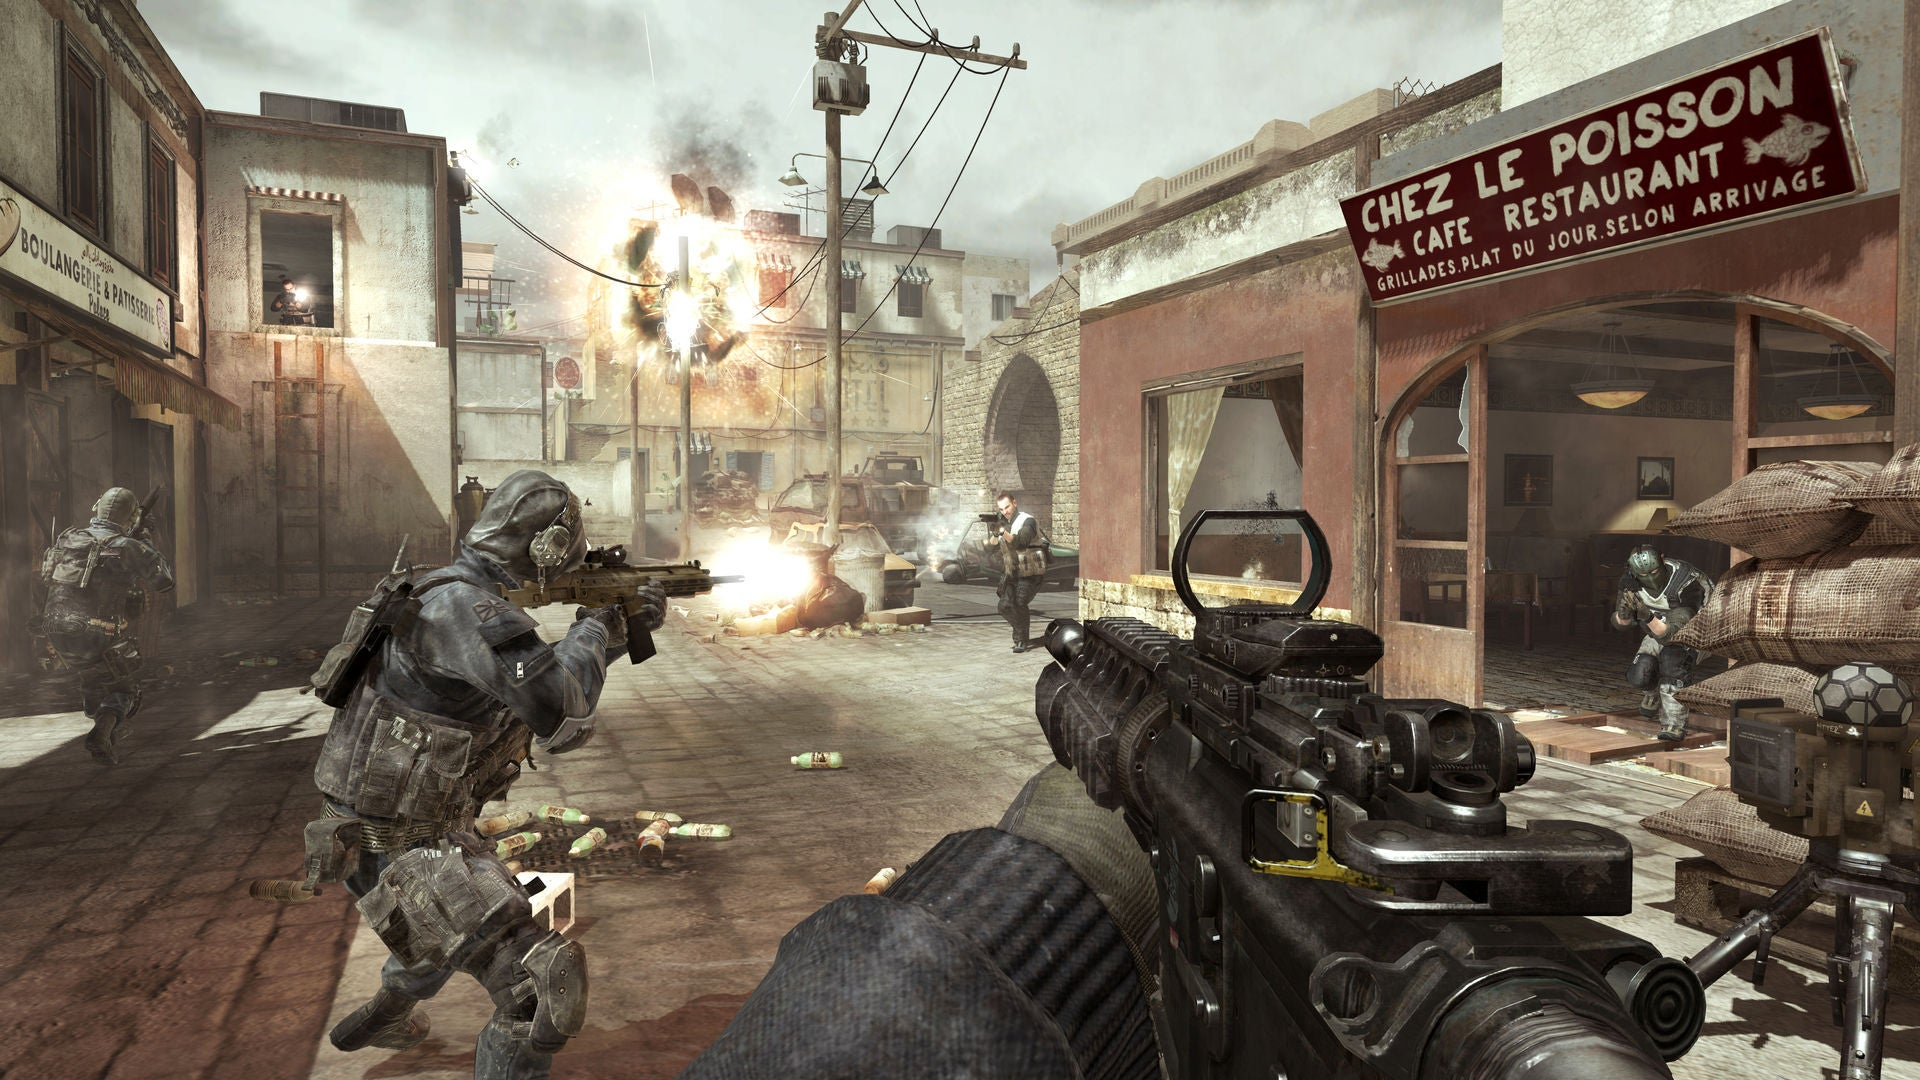

Top categories for the new image:
multiplayer online shooter: Similarity score = 0.2935
tactical shooter: Similarity score = 0.2808
first-person shooter: Similarity score = 0.2776
third-person shooter: Similarity score = 0.2769
open-world shooter: Similarity score = 0.2742
co-op shooter: Similarity score = 0.2742
MMO FPS: Similarity score = 0.2727
stealth game: Similarity score = 0.2703
shooter RPG: Similarity score = 0.2700
open-world FPS: Similarity score = 0.2693


In [ ]:
# Initialize an empty list to store the top N categories and their similarity scores
image_texts_unfiltered = []

# Display and store the top N categories with their similarity scores
for idx in sorted_indices[:top_n]:
    category_name = categories[idx]
    similarity_score = similarity_scores[0][idx]

    # Add the category name and similarity score as a tuple to the list
    image_texts_unfiltered.append((category_name, similarity_score))


# Open the image
img = Image.open(new_image_path)
# Display the image
display(img)

# Optionally, print out the stored categories and similarity scores
print("Top categories for the new image:")
for category, score in image_texts_unfiltered:
    print(f"{category}: Similarity score = {score:.4f}")

# You now have the top N categories stored in `image_texts_unfiltered`


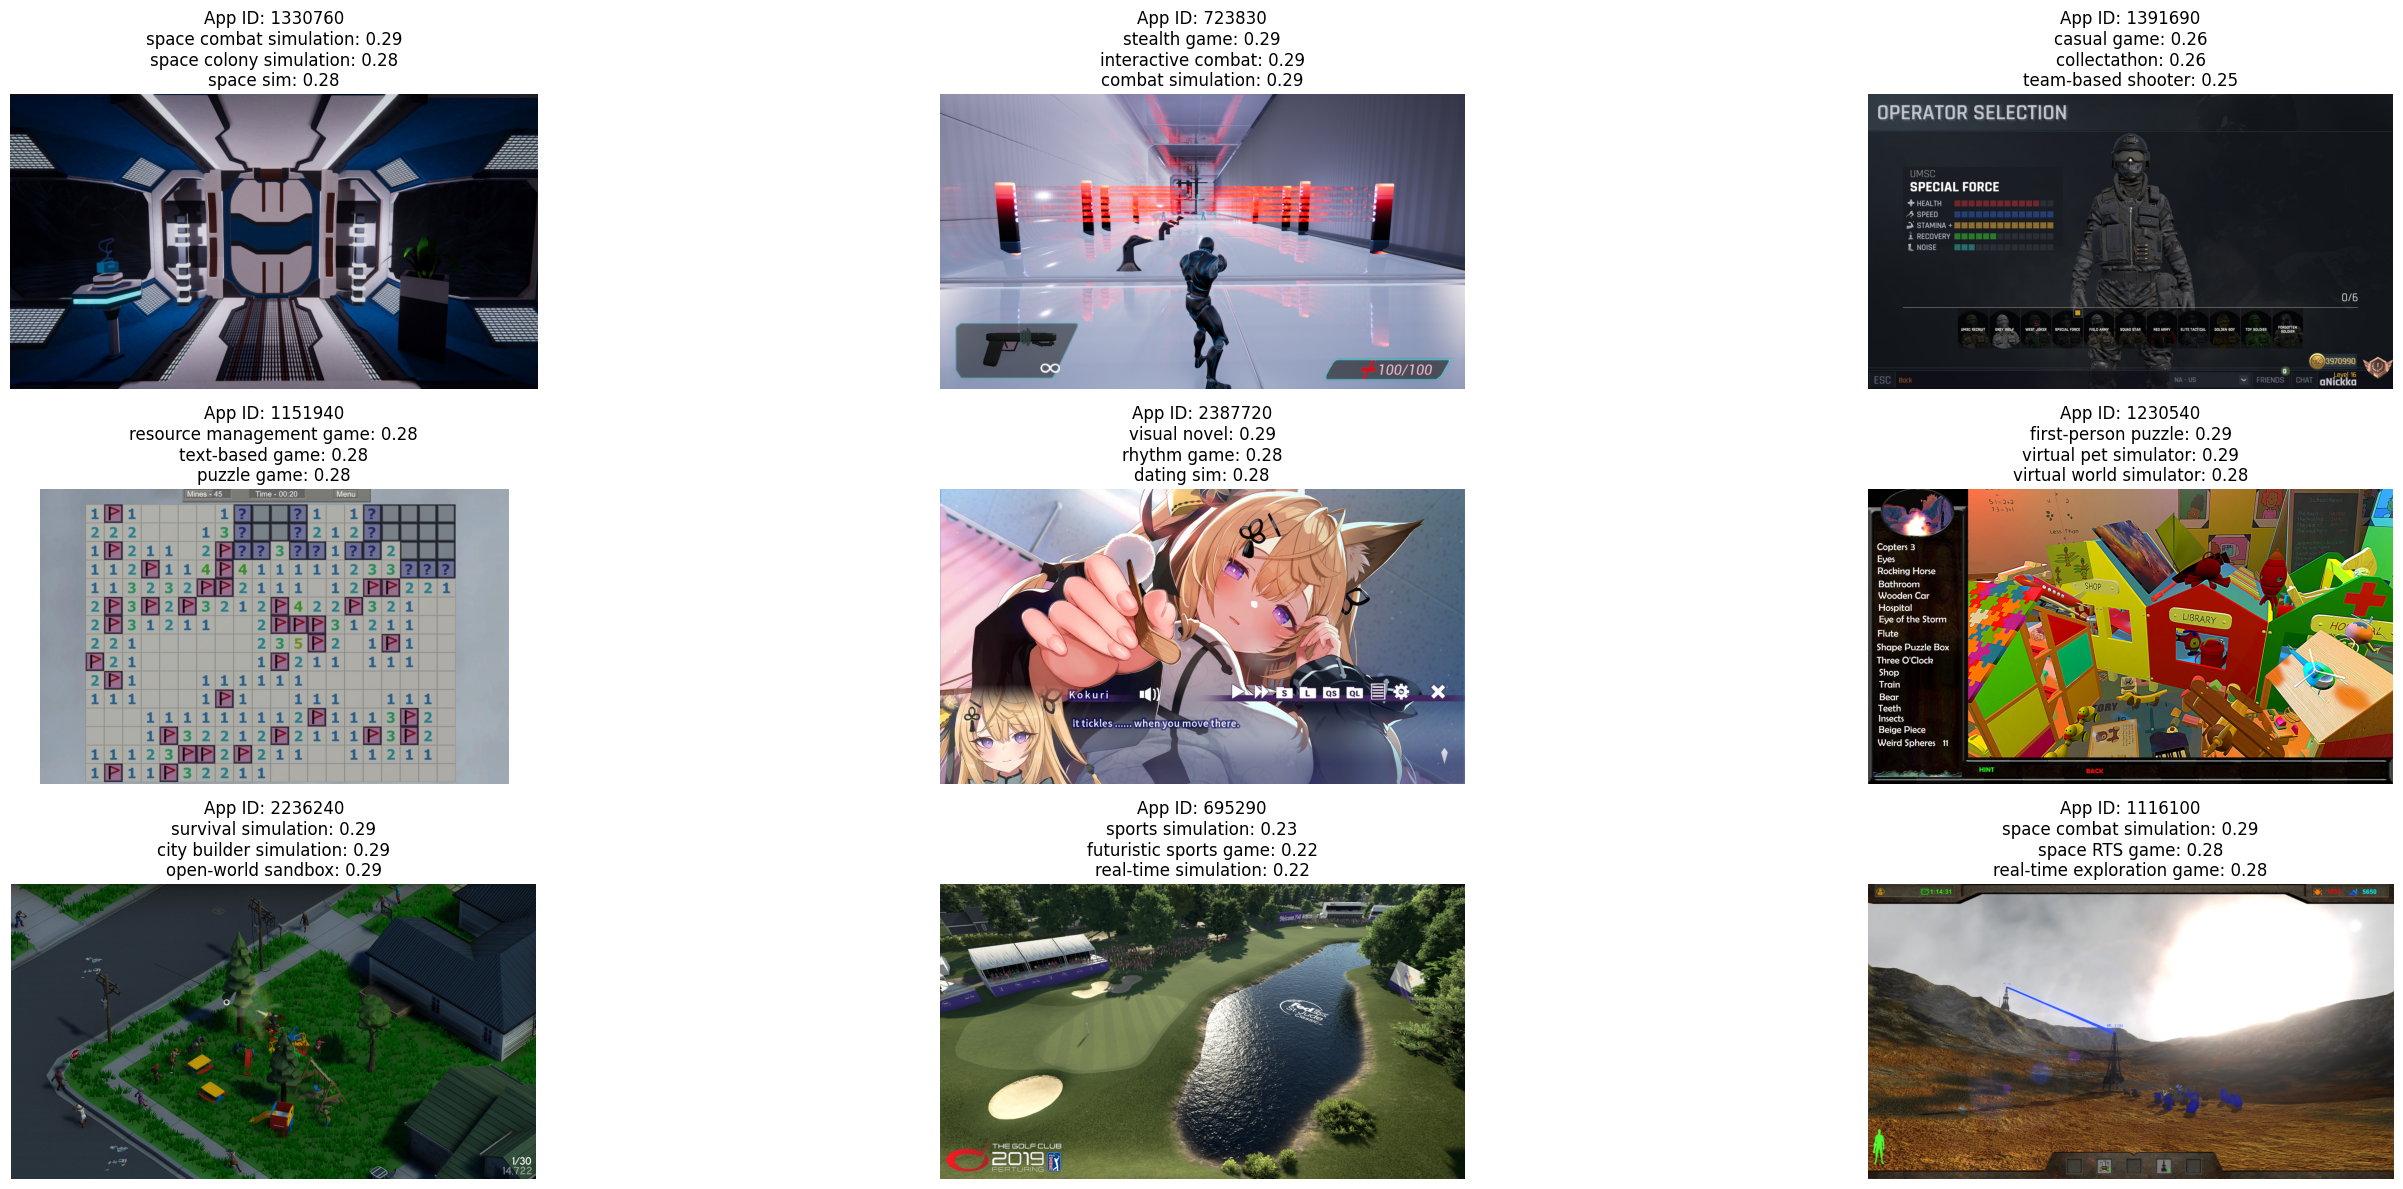

In [25]:
# Load the CLIP model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load the dataset
file_path = "/content/data/data/steam_apps_images.csv"
steam_images = pd.read_csv(file_path)

# Filter only the required columns and images with description = 'screenshot'
images_data = steam_images[steam_images["image_type"] == "screenshot"][["steam_app_id", "image_url"]].dropna()

# Function to validate image URL
def is_url_valid(url):
    try:
        response = requests.head(url, timeout=5)
        return response.status_code == 200
    except requests.RequestException:
        return False

# Randomly select 10 valid images
valid_images = []
while len(valid_images) < 10:
    random_row = images_data.sample(n=1).iloc[0]
    image_url = random_row["image_url"]
    if is_url_valid(image_url):
        valid_images.append((random_row["steam_app_id"], image_url))

# Create a grid to display images and predictions
fig, axes = plt.subplots(3, 3, figsize=(30, 12))
axes = axes.flatten()

for ax, (app_id, url) in zip(axes, valid_images):
    try:
        # Load and preprocess the image
        response = requests.get(url, timeout=10)
        img = Image.open(BytesIO(response.content))
        processed_img = preprocess(img).unsqueeze(0).to(device)

        # Get image features
        with torch.no_grad():
            image_features = model.encode_image(processed_img)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            # Encode category features
            text_features = model.encode_text(text_inputs_categories)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Calculate similarity scores
            similarity_scores = (image_features @ text_features.T).cpu().numpy()

        # Get top 3 predicted categories
        top_n = 3
        sorted_indices = np.argsort(similarity_scores[0])[::-1]
        predictions = [(categories[idx], similarity_scores[0][idx]) for idx in sorted_indices[:top_n]]

        # Display image and predictions
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"App ID: {app_id}\n" + "\n".join([f"{cat}: {score:.2f}" for cat, score in predictions]))
    except Exception as e:
        ax.set_title("Image Load Failed")
        ax.axis("off")

plt.tight_layout()
plt.show()


#  MODEL FOR IMAGE VALUE DATASET

* Generating a dataset with valid urls, steam_app_ids, brightness, saturation, contrast, dominant_hue of images for analysis

* using this dataset to train a decision tree model and performing analysis to find trends in images and game success

## Import libraries

In [29]:
import pandas as pd
import requests
from PIL import Image, ImageStat
from io import BytesIO
from collections import Counter
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

## Generate image dataset

In [30]:
# Load the CSV file
file_path = "/content/data/data/steam_apps_images.csv"
data = pd.read_csv(file_path)

# Function to calculate dominant color (hue)
def calculate_dominant_hue(image):
    # Convert the image to HSV
    image_hsv = image.convert("HSV")
    pixels = np.array(image_hsv)[:, :, 0]  # Extract hue channel
    # Flatten and count frequencies
    hue_counts = Counter(pixels.flatten())
    dominant_hue = max(hue_counts, key=hue_counts.get)
    return dominant_hue

def calculate_attributes(image):
    # Convert to RGB and HSV
    image_rgb = image.convert("RGB")
    image_hsv = image.convert("HSV")
    # Calculate brightness
    stat = ImageStat.Stat(image_rgb)
    brightness = sum(stat.mean) / 3
    # Calculate contrast
    contrast = max(stat.stddev)
    # Calculate saturation
    saturation = max(stat.mean) - min(stat.mean)
    # Calculate dominant hue
    dominant_hue = calculate_dominant_hue(image)
    return brightness, contrast, saturation, dominant_hue

# Initialize a list for the processed data
processed_data = []

# Limit the number of images to process
max_images = 10000
processed_count = 0

# Add progress bar using tqdm
for _, row in tqdm(data.iterrows(), total=max_images, desc="Processing Images"):
    if processed_count >= max_images:
        break

    steam_app_id = row['steam_app_id']
    image_url = row['image_url']

    try:
        # Fetch the image
        response = requests.get(image_url, timeout=10)
        if response.status_code == 404:
            continue  # Skip if the URL returns a 404 error

        image = Image.open(BytesIO(response.content))
        # Calculate attributes
        brightness, contrast, saturation, dominant_hue = calculate_attributes(image)
        # Append the result
        processed_data.append({
            "steam_app_id": steam_app_id,
            "image_url": image_url,
            "brightness": brightness,
            "contrast": contrast,
            "saturation": saturation,
            "dominant_hue": dominant_hue
        })
        processed_count += 1

    except Exception as e:
        print(f"Error processing image {image_url}: {e}")

# Create a DataFrame and save it to a CSV file
output_df = pd.DataFrame(processed_data)
output_df.to_csv("steam_images_attributes1.csv", index=False)
print("Dataset generated and saved as steam_images_attributes1.csv")


Processing Images:   9%|▉         | 921/10000 [08:08<1:23:55,  1.80it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Processing Images: 10001it [1:32:21,  1.80it/s]

Dataset generated and saved as steam_images_attributes1.csv


## train various models

In [105]:
# Load the datasets
attributes_file = "/content/steam_images_attributes1.csv"
info_file = "/content/data/data/steam_apps_info.csv"

steam_images_attributes = pd.read_csv(attributes_file)
steam_apps_info = pd.read_csv(info_file)

# Drop unnecessary columns from steam_apps_info
columns_to_keep = ["steam_app_id", "total_positive_reviews", "total_negative_reviews"]
steam_apps_info = steam_apps_info[columns_to_keep]

# Drop rows with missing values in relevant columns
steam_images_attributes = steam_images_attributes.dropna(subset=["brightness", "contrast", "saturation", "dominant_hue"])
steam_apps_info = steam_apps_info.dropna(subset=["total_positive_reviews", "total_negative_reviews"])

# Merge datasets on steam_app_id
merged_df = pd.merge(steam_images_attributes, steam_apps_info, on="steam_app_id", how="inner")

# Replace total_negative_reviews values of 0 with 1
merged_df["total_negative_reviews"] = merged_df["total_negative_reviews"].replace(0, 1)

# Recalculate the review_ratio
merged_df["review_ratio"] = merged_df["total_positive_reviews"] / merged_df["total_negative_reviews"]

# Log-transform the review ratio if needed
merged_df["review_ratio_log"] = np.log1p(merged_df["review_ratio"])

# Drop unnecessary columns post-merge
merged_df = merged_df.drop(columns=["steam_app_id", "image_url"])

# Define features (X) and target (y)
features = ["brightness", "contrast", "saturation"] + [col for col in merged_df.columns if col.startswith("dominant_hue")]
X = merged_df[features]
y = merged_df["review_ratio"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
# Train a Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate the model
y_pred = dt_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Decision tree Mean Squared Error: {mse}")

Decision tree Mean Squared Error: 269.8358085781452


In [83]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest model
y_rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_rf_pred)

print(f"Random Forest Mean Squared Error: {rf_mse}")


Random Forest Mean Squared Error: 137.4391938102275


In [102]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Evaluate the Gradient Boosting model
y_gb_pred = gb_model.predict(X_test)
gb_mse = mean_squared_error(y_test, y_gb_pred)

print(f"Gradient Boosting Mean Squared Error: {gb_mse}")


Gradient Boosting Mean Squared Error: 130.68720097122053


## visualise outputs and analysis

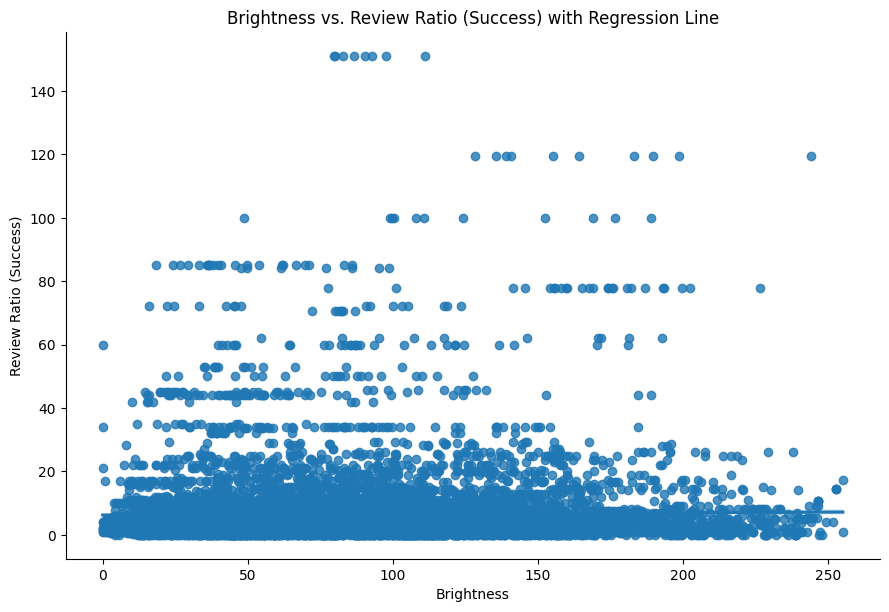

In [38]:
# If you'd like to add a regression line for better understanding of the trend
sns.lmplot(data=merged_df, x='brightness', y='review_ratio', aspect=1.5, height=6)
plt.title('Brightness vs. Review Ratio (Success) with Regression Line')
plt.xlabel('Brightness')
plt.ylabel('Review Ratio (Success)')
plt.show()


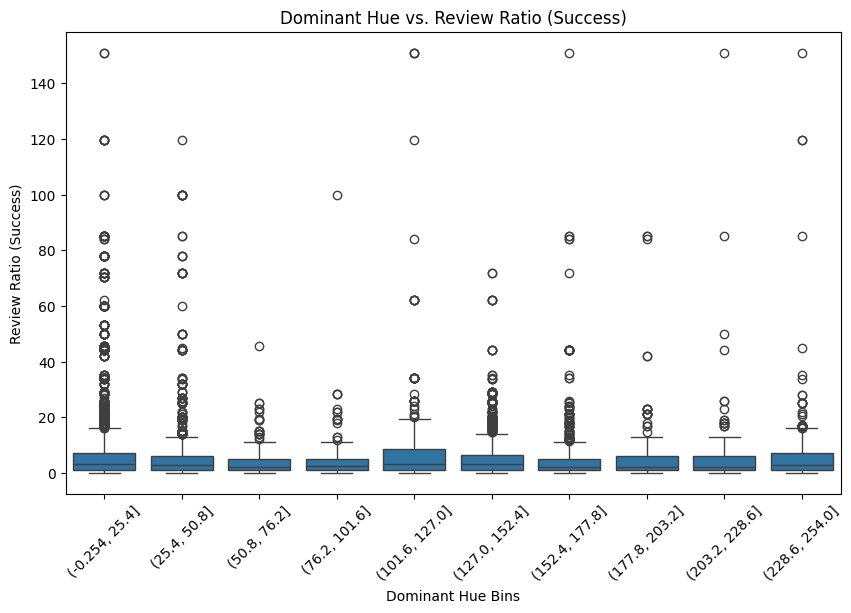

In [39]:
# Bin dominant hue values into categories
merged_df['dominant_hue_bin'] = pd.cut(merged_df['dominant_hue'], bins=10)

# Boxplot to visualize how dominant hue bins affect the review ratio
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='dominant_hue_bin', y='review_ratio')
plt.title('Dominant Hue vs. Review Ratio (Success)')
plt.xlabel('Dominant Hue Bins')
plt.ylabel('Review Ratio (Success)')
plt.xticks(rotation=45)
plt.show()


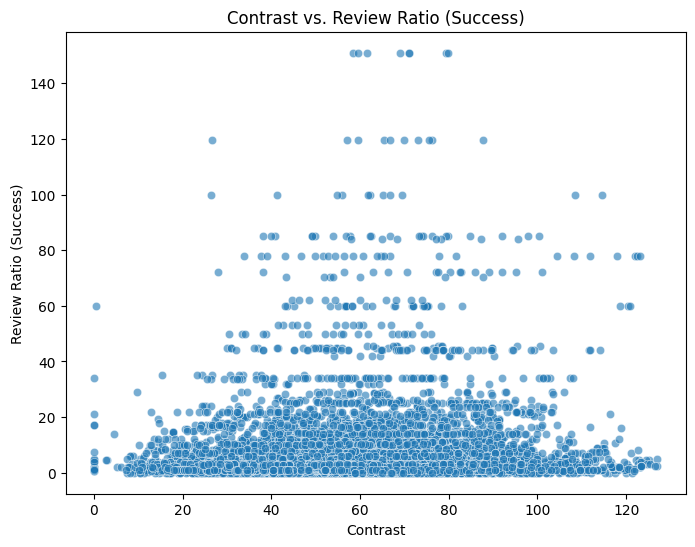

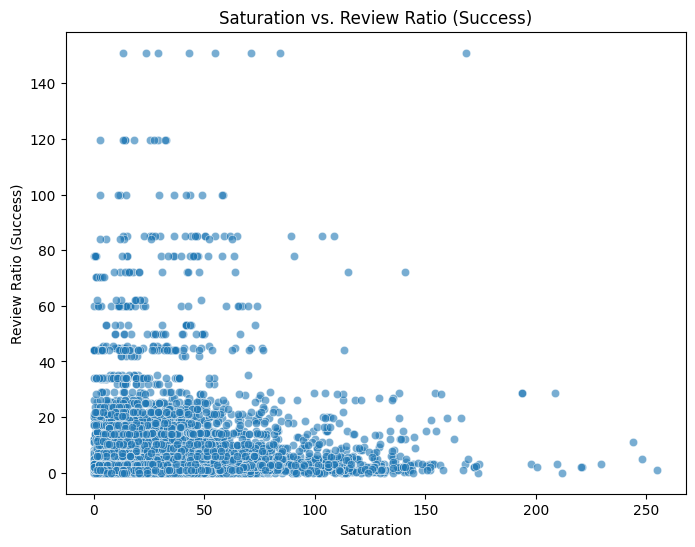

In [40]:
# Scatter plot for contrast vs review ratio
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='contrast', y='review_ratio', alpha=0.6)
plt.title('Contrast vs. Review Ratio (Success)')
plt.xlabel('Contrast')
plt.ylabel('Review Ratio (Success)')
plt.show()

# Scatter plot for saturation vs review ratio
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='saturation', y='review_ratio', alpha=0.6)
plt.title('Saturation vs. Review Ratio (Success)')
plt.xlabel('Saturation')
plt.ylabel('Review Ratio (Success)')
plt.show()


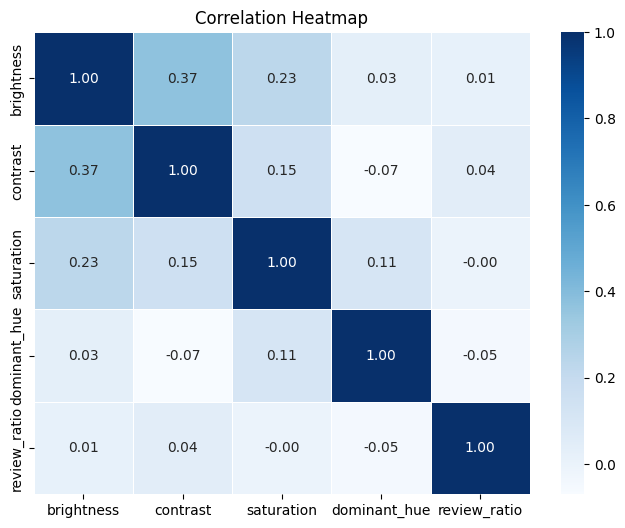

In [41]:
# Calculate the correlation matrix
corr_matrix = merged_df[["brightness", "contrast", "saturation", "dominant_hue"] + ['review_ratio']].corr()

# Heatmap to visualize the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


## Testing model

Attempting to download image from: https://shared.akamai.steamstatic.com/store_item_assets/steam/apps/2516890/ss_df54095820eeaaa43af73b87eb2ebe4eb2a065b0.1920x1080.jpg?t=1718816416 - Status Code: 200
Attempting to download image from: https://shared.akamai.steamstatic.com/store_item_assets/steam/apps/2507540/extras/h4.png - Status Code: 200
Attempting to download image from: https://shared.akamai.steamstatic.com/store_item_assets/steam/apps/2517150/capsule_231x87.jpg?t=1724518471 - Status Code: 200
Attempting to download image from: https://shared.akamai.steamstatic.com/store_item_assets/steam/apps/2504460/ss_632015bbc40bcf8cb0ecfb864cdb7d20b8d76d6d.1920x1080.jpg?t=1691146459 - Status Code: 200
Attempting to download image from: https://shared.akamai.steamstatic.com/store_item_assets/steam/apps/2518660/header.jpg?t=1725026828 - Status Code: 200
Attempting to download image from: https://shared.akamai.steamstatic.com/store_item_assets/steam/apps/2495660/header.jpg?t=1691586487 - Status 

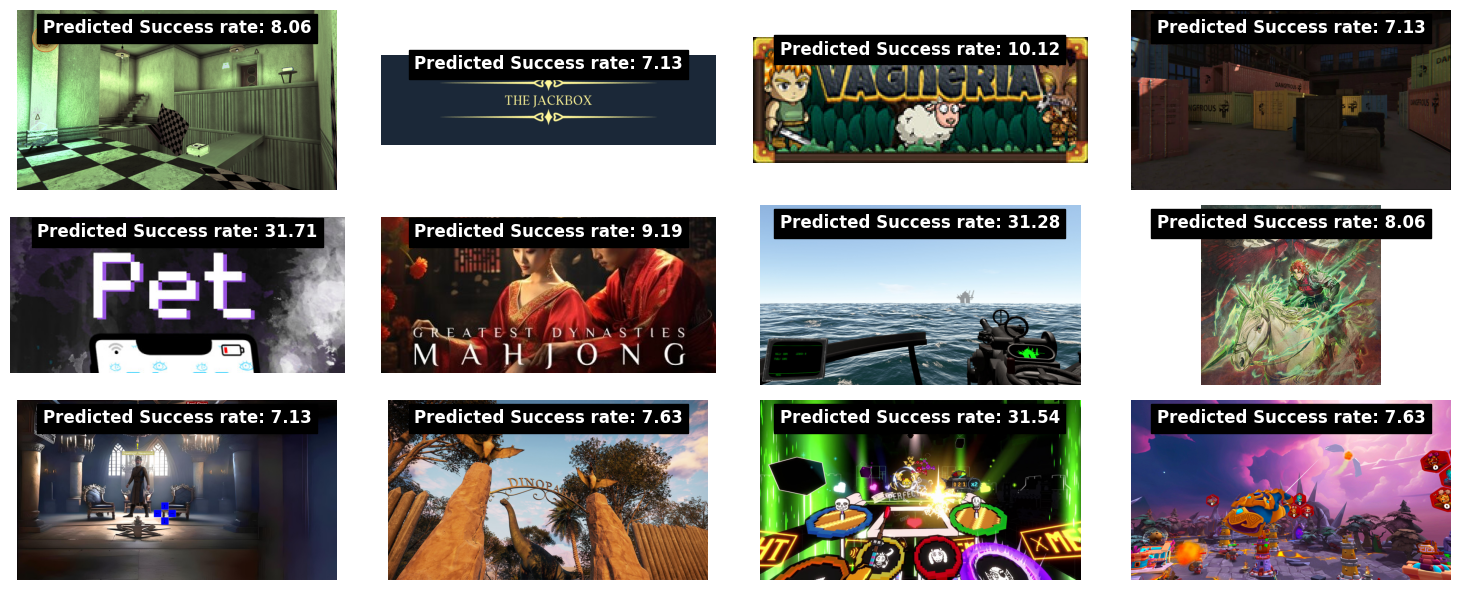

In [136]:
# Randomly sample 10 image URLs
random_image_urls = steam_images_attributes['image_url'].sample(12).tolist()

features = ["brightness", "contrast", "saturation", "dominant_hue"]

# function to return all four features, including dominant_hue
def extract_image_features(image_url):
    if image_url.startswith('http'):
        response = requests.get(image_url)
        image = Image.open(BytesIO(response.content))
        image = np.array(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert PIL image (RGB) to OpenCV (BGR)
    else:
        image = cv2.imread(image_url)

    if image is None:
        return None, None, None, None

    # Convert to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Extract brightness, contrast, and saturation
    brightness = np.mean(hsv_image[:, :, 2]) / 255.0
    saturation = np.mean(hsv_image[:, :, 1]) / 255.0
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contrast = np.std(gray_image) / 255.0

    # Extract the dominant hue (mode of the hue channel)
    hue_values = hsv_image[:, :, 0]
    dominant_hue_result = mode(hue_values, axis=None)

    if dominant_hue_result.count > 0:
        dominant_hue = dominant_hue_result.mode / 179.0  # Normalize to [0, 1]
    else:
        dominant_hue = 0

    return brightness, contrast, saturation, dominant_hue

# function to prepare data for prediction by including the dominant_hue
def prepare_image_for_prediction(image_url):
    brightness, contrast, saturation, dominant_hue = extract_image_features(image_url)

    if brightness is None or contrast is None or saturation is None or dominant_hue is None:
        return None

    # Ensure the number of columns in the input matches the model's expectation
    return pd.DataFrame([[brightness, contrast, saturation, dominant_hue]], columns=features)

# Function to predict success ratio (positive/negative review ratio)
def predict_success(image_url, model):
    features = prepare_image_for_prediction(image_url)

    if features is not None:
        # Use the model to predict success
        predicted_success = model.predict(features)
        return predicted_success[0]  # Return the prediction (positive/negative review ratio)
    else:
        return None


# Function to plot images with prediction overlay (showing the actual image)
def plot_images_with_predictions(image_urls, predictions, grid_size=(2, 5)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 6))
    axes = axes.flatten()

    for i, (url, predicted_success) in enumerate(predictions):
        image = download_image_from_url(url)
        if image:
            axes[i].imshow(image)
            axes[i].axis('off')  # Hide axes
            if predicted_success is not None:
                axes[i].text(0.5, 0.9, f"Predicted Success rate: {predicted_success:.2f}", color='white', ha='center', va='center', fontsize=12, fontweight='bold', transform=axes[i].transAxes, backgroundcolor='black')
            else:
                axes[i].text(0.5, 0.9, "No Prediction", color='white', ha='center', va='center', fontsize=12, fontweight='bold', transform=axes[i].transAxes, backgroundcolor='black')
        else:
            axes[i].axis('off')
            axes[i].text(0.5, 0.5, "Image Not Found", color='black', ha='center', va='center', fontsize=12, fontweight='bold', transform=axes[i].transAxes)

    plt.tight_layout()
    plt.show()

# Example usage:
predictions = []
for url in random_image_urls:
    predicted_success = predict_success(url, gb_model)
    predictions.append((url, predicted_success))

# Plot the images with their predictions in a grid
plot_images_with_predictions(random_image_urls, predictions, grid_size=(3, 4))
